In [1]:
import psycopg2
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from joblib import dump, load

## Connection to the db & saving csv files for train and test

In [2]:
# # Create a connection to the database
# conn = psycopg2.connect(
#     host="prod-rds-db.cbijryjiwdgw.eu-west-3.rds.amazonaws.com",
#     user="testdata",
#     password="testData678341A",
#     database="prodkbdb",
#     port="5432"
# )

# # Create a cursor object to execute queries
# cursor = conn.cursor()

# # Select the first 50000 rows for training
# cursor.execute("SELECT * FROM items LIMIT 50000;")

# # Fetch all the rows from the result
# rows = cursor.fetchall()

# # Define the path and filename of the CSV file
# csv_file_path = "./Data/items.csv"

# # Write the rows to the CSV file
# with open(csv_file_path, "w", newline="", encoding="utf-8") as csv_file:
#     csv_writer = csv.writer(csv_file)
#     csv_writer.writerow([desc[0] for desc in cursor.description])
#     csv_writer.writerows(rows)
    
# # Select the next 500 rows for test
# cursor.execute("SELECT * FROM items LIMIT 500 OFFSET 50000;")

# # Fetch the next 500 rows from the result
# rows = cursor.fetchall()

# # Define the path and filename of the second CSV file
# csv_file_path2 = "./Data/items_test.csv"

# # Write the next 500 rows to the second CSV file
# with open(csv_file_path2, "w", newline="", encoding="utf-8") as csv_file:
#     csv_writer = csv.writer(csv_file)
#     csv_writer.writerow([desc[0] for desc in cursor.description])
#     csv_writer.writerows(rows)

# # Close the cursor and the connection
# cursor.close()
# conn.close()


## Data setup

In [3]:
# Import train data as a DataFrame
train_dataset = pd.read_csv("./Data/items.csv")

In [4]:
train_dataset.head(10)

,id,amount,description,date,itemName,parent,quantity,taxAmount,taxDescription,type,storeId,createdAt,updatedAt,taxRate
0,c056e002-276e-4420-a797-89f3ef0ae986,12.40,NaN,NaN,galette belle-iloise,NaN,NaN,0.29,TVA 10 %,NaN,7f912b1c-5974-4697-a45f-15ac13abd382,2023-06-20 11:51:20.209000+00:00,2023-06-20 11:51:20.209000+00:00,1000
1,7793798e-1ce7-4b0a-9df6-fb5942df72e0,11.90,NaN,NaN,pizza reine,NaN,NaN,0.28,TVA 10 %,NaN,7f912b1c-5974-4697-a45f-15ac13abd382,2023-06-20 11:51:21.050000+00:00,2023-06-20 11:51:21.050000+00:00,1000
2,2fbbf113-caf1-41d3-ba89-bf4b20ac2cd9,16.50,NaN,NaN,chirashi saumon,NaN,NaN,1.50,TVA 10 %,NaN,6cd6003f-f1ee-47bb-b84e-6138109765e6,2023-06-20 11:52:58.635000+00:00,2023-06-20 11:52:58.635000+00:00,1000
3,3cba5797-6ae9-4844-9219-2bab8bb59894,1.80,NaN,NaN,espresso,NaN,NaN,0.33,TVA 10 %,NaN,36d035e9-93d2-455a-b374-a75016690bca,2023-06-20 11:53:35.238000+00:00,2023-06-20 11:53:35.238000+00:00,1000
4,c688fe32-a0f6-42cc-b603-f611d0127e17,2.80,NaN,NaN,heineken 25cl,NaN,NaN,0.47,TVA 20 %,NaN,c1de54ac-d6e3-4366-80aa-6ce7289df819,2023-06-20 11:53:48.486000+00:00,2023-06-20 11:53:48.486000+00:00,2000
5,afecca6b-aa95-45a7-ac21-342029363fda,4.55,NaN,NaN,assiette noire,NaN,NaN,0.41,TVA 10 %,NaN,9e693ae5-0378-47fc-bfb3-165308948997,2023-06-20 11:53:49.142000+00:00,2023-06-20 11:53:49.142000+00:00,1000
6,113e23c3-2d58-4cf9-9d2b-e195a578e812,13.00,NaN,NaN,calzone faecito,NaN,NaN,1.19,TVA 10 %,NaN,9bca5b80-c54a-4aa2-8cfb-724b5aa198d4,2023-06-20 11:53:59.144000+00:00,2023-06-20 11:53:59.144000+00:00,1000
7,92e31c6f-cc42-42fa-96ad-acef9feb8e51,3.00,NaN,NaN,verre de rose,NaN,NaN,0.50,TVA 20 %,NaN,9bca5b80-c54a-4aa2-8cfb-724b5aa198d4,2023-06-20 11:53:59.739000+00:00,2023-06-20 11:53:59.739000+00:00,2000
8,b7d1e104-df96-4b58-9add-4a92542f1fdc,3.50,NaN,NaN,fougasse olives,NaN,NaN,0.19,TVA 5.5 %,NaN,036b92f5-eb77-463c-8e5b-121105fbd501,2023-06-20 11:54:38.861000+00:00,2023-06-20 11:54:38.861000+00:00,550
9,fc07f6f2-3b82-4fb3-9e86-f4d125f7e189,2.00,café allongé,NaN,café allongé,NaN,NaN,0.19,TVA 10 %,NaN,a81f845b-0f2f-4d4c-8090-f139ca03f2cd,2023-06-20 11:55:06.059000+00:00,2023-06-20 11:55:06.059000+00:00,1000


In [5]:
# Explore raw dataset
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              50000 non-null  object 
 1   amount          50000 non-null  float64
 2   description     3716 non-null   object 
 3   date            0 non-null      float64
 4   itemName        50000 non-null  object 
 5   parent          0 non-null      float64
 6   quantity        0 non-null      float64
 7   taxAmount       50000 non-null  float64
 8   taxDescription  50000 non-null  object 
 9   type            2436 non-null   object 
 10  storeId         50000 non-null  object 
 11  createdAt       50000 non-null  object 
 12  updatedAt       50000 non-null  object 
 13  taxRate         50000 non-null  int64  
dtypes: float64(5), int64(1), object(8)
memory usage: 5.3+ MB


In [6]:
# Count the null values
train_dataset.isna().sum()

id                    0
amount                0
description       46284
date              50000
itemName              0
parent            50000
quantity          50000
taxAmount             0
taxDescription        0
type              47564
storeId               0
createdAt             0
updatedAt             0
taxRate               0
dtype: int64

## Feature selection & cleaning 

In [7]:
# drop duplicates
train_dataset = train_dataset.drop_duplicates()

# drop the columns that have a lot of null values, id columns, createdAt and updatedAt "no impact on data"
# drop taxDescription because it's highly correlated with taxRate
train_dataset = train_dataset.drop(columns=["description", "date", "parent", "quantity", "type", "id", "createdAt", "updatedAt", "taxDescription"], axis=1)


In [8]:
# drop incoherent data such as nagative or zero amount or taxAmount
train_dataset = train_dataset.drop(train_dataset[train_dataset["amount"] <= 0].index)
train_dataset = train_dataset.drop(train_dataset[train_dataset["taxAmount"] <= 0].index)

In [9]:
train_dataset.sample(6)

,amount,itemName,taxAmount,storeId,taxRate
25746,2.50,cookies,0.14,5b326484-bf83-4fca-8143-7688fe4b7a76,550
49814,3.45,california saumon avocat,0.18,7345f547-e328-4617-ae0a-65e0ce63b81a,550
43523,2.71,salembo,0.15,e8c01ac2-c866-4cf4-ad5b-3f54a4946a8d,550
19145,7.00,the glace peche,0.64,abb75357-5ad6-4aa0-b0c4-d903b67f8727,1000
39317,13.95,formule poulet 🥙🍟🥤,1.18,5021d7cd-c824-4be7-9d45-3adbae909d51,0
7400,34.00,bourgogne domaine george roy,5.67,47049def-eb8b-47eb-a13e-c1de63d6cd90,2000


## Features preprocessing

In [10]:
# Select the numerical and categorical columns
num_features = ["amount", "taxAmount", "taxRate"]
cat_features = ["itemName", "storeId"]

# Initiate an encoder,scaler and a processor
encoder = OneHotEncoder(handle_unknown="ignore")
scaler = StandardScaler()
processor = ColumnTransformer(transformers=[("encoder", encoder, cat_features), ("scaler", scaler, num_features)])
dataset_processed = processor.fit_transform(train_dataset)

# Persist the encoder,scaler and processor artefacts 
dump(encoder, "./Models/encoder.joblib")
dump(scaler, "./Models/scaler.joblib")
dump(processor, "./Models/processor.joblib")

['./Models/processor.joblib']

## Selection of optimum number of clusters(Elbow method)

C:\Users\Mohamed Amine\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


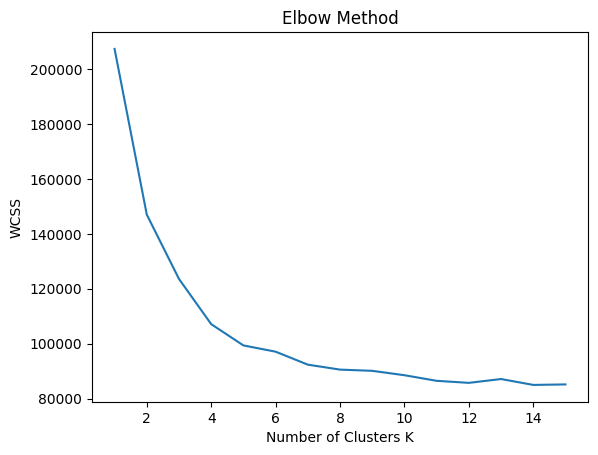

In [11]:
# Define empty list of wcss(inertia) values
wcss = []

# Specify the maximum number of clusters you want to consider
max_clusters = 15

for K in range(1, max_clusters+1):
    # Fit K-means clustering model
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(dataset_processed)
    
    wcss.append(kmeans.inertia_)

# Plot the WCSS values against the number of clusters
plt.plot(range(1, max_clusters+1), wcss)
plt.xlabel('Number of Clusters K')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

## Model training

In [12]:
# According to the Elbow graph the optimum value of K is 4 since beyond this value clusters have not a big effect on classes

# Train the model
items_kmeans = KMeans(n_clusters = 4, random_state=42)
items_kmeans.fit(dataset_processed)

# Persist the model artefact
dump(items_kmeans, "./Models/model.joblib")

y_pred = items_kmeans.predict(dataset_processed)



## Vizualisation of the clusters

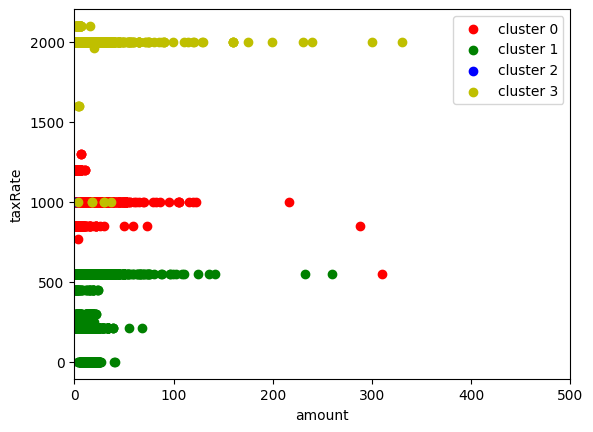

In [13]:
colors = ["r", "g", "b", "y"]
for cluster in range(0, 4):
    data_points = train_dataset[y_pred == cluster].reset_index(drop=True)
    plt.scatter(data_points["amount"], data_points["taxRate"], color=colors[cluster], label=f"cluster {cluster}")
    
plt.legend()
plt.xlabel("amount")
plt.ylabel("taxRate")
plt.xlim(0, 500) # i have limited the x axis to 500 to see better the points, the cluster 2 is hidden because 
                 #there is only few points that are above the 2000, if you want to see all the points delete this code line
plt.show()

In [14]:
cluster_labels = items_kmeans.labels_
train_dataset["cluster"] = cluster_labels

In [15]:
train_dataset.sample(100)

,amount,itemName,taxAmount,storeId,taxRate,cluster
34336,18.50,salmon dream,1.68,6d177370-8482-44dd-9be0-7ae159cdca4a,1000,0
19523,14.95,formule das poivrons 🫑,1.27,897a3d79-b358-4a76-b9bb-f72c857a5565,0,1
43861,2.59,fuzetea pêche,0.14,bcf985e3-f7cb-4d0e-a39c-9ecefebf3b2d,550,1
29563,4.50,33 cl pression,0.75,7c0ea322-a350-474f-9b09-1f171e4bcc31,2000,3
44671,1.21,coca cola 33cl,0.11,fbe1f03d-6e87-477b-948d-edeb515c574d,1000,0
...,...,...,...,...,...,...
48172,26.00,"1,5 st idesbald triple",4.34,e3c96dbf-92b8-4b09-b895-00f410f51149,2000,3
45402,3.52,frites,0.32,e8322b45-4c21-49a9-9017-0726fbf76620,1000,0
44665,11.52,simple poivre,1.05,162da2e6-bc67-4d08-b99c-5929f1bcdc1b,1000,0
18677,4.20,cappuccino,0.39,c7985e3d-4c27-4b3a-b5be-2b6de12e8b23,1000,0


## Exploration of the clusters

In [16]:
cluster0 = train_dataset[train_dataset["cluster"] == 0]
cluster0

,amount,itemName,taxAmount,storeId,taxRate,cluster
0,12.40,galette belle-iloise,0.29,7f912b1c-5974-4697-a45f-15ac13abd382,1000,0
1,11.90,pizza reine,0.28,7f912b1c-5974-4697-a45f-15ac13abd382,1000,0
2,16.50,chirashi saumon,1.50,6cd6003f-f1ee-47bb-b84e-6138109765e6,1000,0
3,1.80,espresso,0.33,36d035e9-93d2-455a-b374-a75016690bca,1000,0
5,4.55,assiette noire,0.41,9e693ae5-0378-47fc-bfb3-165308948997,1000,0
...,...,...,...,...,...,...
49991,10.90,le pulled pork,0.99,9a87ba6c-e9c8-42c6-b068-55d5d2cc8f89,1000,0
49992,10.90,simple pulled pork,0.99,9a87ba6c-e9c8-42c6-b068-55d5d2cc8f89,1000,0
49994,4.50,maki avocat cheese,0.41,27174320-f51e-47cb-a84a-c48f5a312df0,1000,0
49995,3.50,orangina 33cl,0.32,a034467c-bd4d-4389-a531-c0ae95fb1a6c,1000,0


In [17]:
cluster1 = train_dataset[train_dataset["cluster"] == 1]
cluster1

,amount,itemName,taxAmount,storeId,taxRate,cluster
8,3.50,fougasse olives,0.19,036b92f5-eb77-463c-8e5b-121105fbd501,550,1
18,1.36,maltesers biscuits 110g,0.08,a2c85c81-2e60-472d-bda6-16422a79156b,550,1
23,2.70,coca zéro 33cl,0.14,5021d7cd-c824-4be7-9d45-3adbae909d51,550,1
25,17.95,formule boeuf 🥙🍟🥤,1.51,40d887b9-fb99-42e1-a828-0fd25015f78d,0,1
28,3.24,fanta orange 33cl,0.17,40d887b9-fb99-42e1-a828-0fd25015f78d,550,1
...,...,...,...,...,...,...
49977,2.80,*badoit,0.15,90702bdb-779f-4d00-88dd-3ad300c989b6,550,1
49978,2.35,tropico tropical 33cl,0.12,5021d7cd-c824-4be7-9d45-3adbae909d51,550,1
49989,4.68,maki thon spicy,0.24,88bd33c4-4eb0-48d1-ac5b-0aa724ec57a6,550,1
49990,4.61,california saumon avocat,0.24,88bd33c4-4eb0-48d1-ac5b-0aa724ec57a6,550,1


In [18]:
cluster2 = train_dataset[train_dataset["cluster"] == 2]
cluster2

,amount,itemName,taxAmount,storeId,taxRate,cluster
4110,10000.0,menu carnivore,198.02,6a5a8304-1467-4f31-96a4-53bd627c5095,100,2
8457,8000.0,proscuitto,79.21,6a5a8304-1467-4f31-96a4-53bd627c5095,100,2
10930,10000.0,menu carnivore,99.01,6a5a8304-1467-4f31-96a4-53bd627c5095,100,2
11994,10000.0,menu carnivore,297.03,6a5a8304-1467-4f31-96a4-53bd627c5095,100,2
15405,10000.0,menu carnivore,297.03,6a5a8304-1467-4f31-96a4-53bd627c5095,100,2
16197,15500.0,filet de bœuf grillé,306.93,6a5a8304-1467-4f31-96a4-53bd627c5095,100,2
17162,10000.0,menu carnivore,198.02,6a5a8304-1467-4f31-96a4-53bd627c5095,100,2
17169,10000.0,menu carnivore,99.01,6a5a8304-1467-4f31-96a4-53bd627c5095,100,2
19270,18500.0,t-bone angus,183.17,6a5a8304-1467-4f31-96a4-53bd627c5095,100,2
22083,10000.0,menu carnivore,99.01,6a5a8304-1467-4f31-96a4-53bd627c5095,100,2


In [19]:
cluster3 = train_dataset[train_dataset["cluster"] == 3]
cluster3

,amount,itemName,taxAmount,storeId,taxRate,cluster
4,2.80,heineken 25cl,0.47,c1de54ac-d6e3-4366-80aa-6ce7289df819,2000,3
7,3.00,verre de rose,0.50,9bca5b80-c54a-4aa2-8cfb-724b5aa198d4,2000,3
13,4.50,verre aquilé,0.75,6ffd4ff8-c9e3-4855-a249-922b862289ae,2000,3
21,5.00,bière du comté 33cl,0.84,3855af02-ef8b-4e89-a2e0-3a71462232d3,2000,3
22,4.81,caramel macchiato medium,0.84,2dc8ab66-a05b-4b16-8a74-a8d29f3ee405,2100,3
...,...,...,...,...,...,...
49965,4.50,1/2 chimay tripel,0.75,0cd6bdc2-b896-4b39-ac71-88ffc26590ed,2000,3
49987,9.31,50 guillotine,1.56,e3c96dbf-92b8-4b09-b895-00f410f51149,2000,3
49988,9.00,50 red,1.50,e3c96dbf-92b8-4b09-b895-00f410f51149,2000,3
49997,12.00,monkey shoulder,2.00,ea23eeb4-5055-4258-8f4e-1d4ec59203f9,2000,3


In [20]:
# I noticed that the clusters are related to taxRate column so i'll investigate the different values for each class

cluster0.taxRate.unique()

array([1000,  850, 1200, 1300,  770,  550], dtype=int64)

In [21]:
cluster1.taxRate.unique()

array([550,   0, 210, 300, 450, 250, 100], dtype=int64)

In [22]:
cluster2.taxRate.unique()

array([ 100, 1000], dtype=int64)

In [23]:
cluster3.taxRate.unique()

array([2000, 2100, 1000, 1600, 1961], dtype=int64)

#### Based on the results above i did some research and i found out that TVA is splitted to multiple classes so i will consider the clusters as follow:
cluster3 : normal_tax_rate, 
cluster2 : particular_tax_rate, 
cluster1 : reduced_tax_rate, 
cluster0 : intermediate_tax_rate

## Building prediction function

In [24]:
# Define features as constants
features = ["amount", "itemName", "taxAmount", "storeId", "taxRate"]
num_features = ["amount", "taxAmount", "taxRate"]
cat_features = ["itemName", "storeId"]

# Load the saved artefacts:
loaded_encoder = load("./Models/encoder.joblib")
loaded_scaler = load("./Models/scaler.joblib")
loaded_processor = load("./Models/processor.joblib")
loaded_model = load("./Models/model.joblib")

# Prediction function
def item_class_pred(test_dataset: pd.DataFrame) -> pd.DataFrame:
    test_dataset = test_dataset.loc[:, features]
    dataset_preprocess = loaded_processor.transform(test_dataset)
    prediction = loaded_model.predict(dataset_preprocess)
    # Add column cluster to the dataset
    test_dataset["cluster"] = prediction
    # map the values of clusters
    cluster_dict = {0: "intermediate_tax_rate", 1: "reduced_tax_rate", 2: "particular_tax_rate", 3: "normal_tax_rate"}
    test_dataset["cluster"] = test_dataset["cluster"].replace(cluster_dict)
    return test_dataset.loc[:, ["itemName", "cluster"]]

## Prediction of the items_test.csv

In [25]:
test_data = pd.read_csv("./Data/items_test.csv")
item_class_pred(test_data)

,itemName,cluster
0,give me more,reduced_tax_rate
1,gallia w 50cl,normal_tax_rate
2,la bon vent neipa,normal_tax_rate
3,menu provencal,intermediate_tax_rate
4,simple provençal,intermediate_tax_rate
...,...,...
495,pot bbq,intermediate_tax_rate
496,dr pepper,reduced_tax_rate
497,33 cl pression,normal_tax_rate
498,demi sirop,intermediate_tax_rate
